# 기계학습 - 분류

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None

# 한글 깨짐 방지
from matplotlib import font_manager, rc
path = './file/malgun.ttf'
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family = font_name)

## 데이터 로딩

In [6]:
df = pd.read_csv('./data/bikeshare.csv')

## 데이터 구조 확인 및 EDA

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.shape

In [ ]:
df.info()

### 데이터 타입 보정

In [ ]:
df.columns

In [12]:
# type별로 컬럼 분류
col_id = []
col_dt = ['datetime']
col_cat = ['season']
col_int = ['weather', 'humidity','casual','registered','count']
col_float = ['temp','atemp','windspeed']
col_bool = ['holiday','workingday']
col_num = col_int + col_float

In [13]:
df['datetime'] = pd.to_datetime(df['datetime'])
df[col_cat]= df[col_cat].astype('str')
df[col_int] = df[col_int].astype('int', errors='ignore')
df[col_float] = df[col_float].astype('float')

In [ ]:
df.describe()

In [ ]:
df.describe(include='object')

### 시각화

<AxesSubplot:xlabel='season', ylabel='casual'>

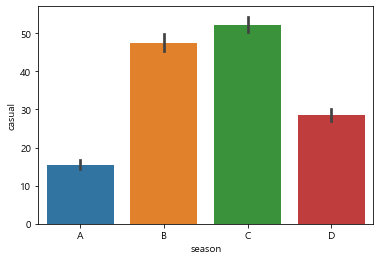

In [16]:
sns.barplot(x='season', y='casual', data=df)

<AxesSubplot:xlabel='count', ylabel='season'>

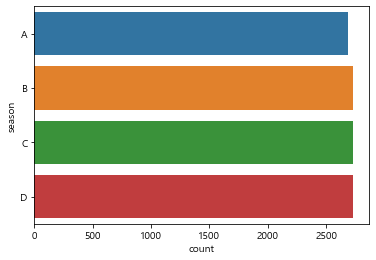

In [17]:
# 범주형(또는 가지수가 많지 않은 연속형) 변수의 데이터별 count
sns.countplot(y = 'season', data = df)

## 전처리

### 중복값

In [ ]:
# 중복값 확인
df[df.duplicated(keep=False)] 

In [ ]:
df.drop_duplicates() # 행 내용이 동일한 경우 제거
df.drop_duplicates(['col1'], keep='last') # col1기준 중복값중 마지막만 남겨둠

### 결측치

In [ ]:
df.isna().sum()

In [ ]:
# na 처리 : dropna(), fillna()
df.dropna() # nan이 하나라도 들어간 행은 삭제
df.dropna(how = 'all') # 데이터가 모두 nan인 행만 삭제 / 초기값:'any'
## Parameters
# axis = 'index' / 'columns'
# subset = ['col1', 'col2', ...] # 적용 대상 컬럼 특정

df.fillna(0) # na를 0으로 채우기

# 평균값, 중앙값으로 대치
df.loc[19,'Leaflets'] = df['Leaflets'].mean() # 평균값으로 
df.loc[19,'Leaflets'] = df['Leaflets'].median # 중앙값으로

### 이상치

<AxesSubplot:xlabel='humidity'>

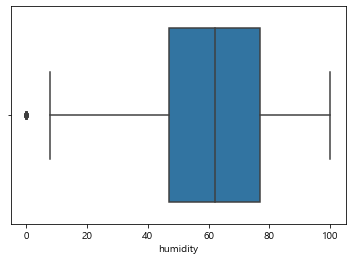

In [22]:
tmp = 'humidity'
sns.boxplot(y = tmp, data = df, orient = 'h')

In [ ]:
# IQR 활용
q1 = df[tmp].quantile(.25)
q3 = df[tmp].quantile(.75)
iqr = q3-q1
min_iqr = q1 - 1.5 * iqr
max_iqr = q3 + 1.5 * iqr
min_from_all = df[tmp].min()
max_from_all = df[tmp].max()
if (min_iqr < min_from_all) :
    min_iqr = min_from_all
if (max_iqr > max_from_all) :
    max_iqr = max_from_all

outlier = df[(df[tmp] < min_iqr ) | (df[tmp] > max_iqr)] # 이상치 조회
outlier_index = outlier.index
print(outlier.shape)
outlier

In [ ]:
df.loc[(df[tmp] < min_iqr ),tmp] = min_iqr # 이상치 보정 - 하한치로 보정
df.loc[(df[tmp] > max_iqr ),tmp] = max_iqr # 이상치 보정 - 상한치로 보정

In [ ]:
df = df.drop(outlier_index, axis=0)
df.shape

## 변수 더미화

In [26]:
import statsmodels.api as sm
from patsy import dmatrices

y, X = dmatrices('y2 ~ season + holiday + workingday+weather+temp+atemp+humidity+windspeed+casual\
+registered', data=df, return_type='dataframe')

## 종속변수 분포 확인

In [ ]:
temp = y.value_counts() # y.value_counts().sort_index()
temp.name='count'
temp.to_frame()

## train, test set split

In [44]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.3, random_state=0)

## StandardScaler

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_tr_s = scaler.transform(X_train)
X_te_s = scaler.transform(X_test)

In [46]:
# 컬럼명 다시 붙여주기
X_tr_s = pd.DataFrame(X_tr_s, columns= X_train.columns)
X_te_s = pd.DataFrame(X_te_s, columns= X_test.columns)

## 오버샘플링 진행

In [ ]:
y_train.value_counts()

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_tr_o, y_tr_o = smote.fit_sample(X_tr_s, y_train)

In [51]:
# 컬럼명 다시 붙여주기
X_tr_o = pd.DataFrame(X_tr_o, columns= X_train.columns)
y_tr_o = pd.DataFrame(y_tr_o, columns=['y2'])

In [ ]:
y_tr_o.value_counts()

## 모델링 및 기초 모델 선정

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [55]:
# Evaluate Algorithms
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'
# num_instances = len(X_train_over)

In [56]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('MLP', MLPClassifier()))

In [ ]:
results = []
names = []

from sklearn.model_selection import StratifiedKFold # 층화추출 시
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
# kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

for name, model in models:
    cv_results = cross_val_score(model, X_tr_o, y_tr_o.values.ravel(), cv=skf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "[%s]\tmean: %f\tstd: %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [59]:
names
for i in range(len(names)):
    print(names[i], np.mean(results[i]))

LR 0.9923020026766084
LDA 0.9315374167542938
KNN 0.9516657903960744
CART 0.9924912372940764
NB 0.9114712981550521
RF 0.9934376891947869
MLP 0.9963403355319759


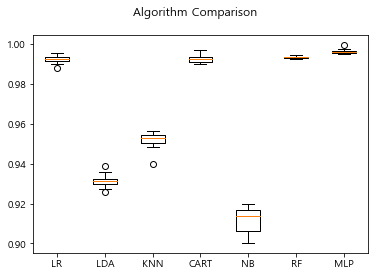

In [58]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## 파라미터 튜닝

In [ ]:
model = RandomForestClassifier()

n_estimators_set = [5, 10, 15, 20, 25, 30, 35, 40]
max_features_set = ["sqrt", "log2", None]
param_grid = dict(n_estimators = n_estimators_set,
                  max_features = max_features_set)

grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = skf)
grid_result = grid.fit(X_tr_o, y_tr_o.values.ravel())
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

a = grid_result.cv_results_

for i in range(len(a['rank_test_score'])):
    print('%f (%f) with: %r' %(a['mean_test_score'][i], a['std_test_score'][i], a['params'][i]))

# for params, mean_score, scores in grid_result.cv_results_:  ## 얘 에러난다
#     print('%f (%f) with: %r' %(mean_test_score.mean(), std_test_score.mean(), params))

In [61]:
fine_tuned_RF = grid_result.best_estimator_
print('best params: ', grid_result.best_params_)
fine_tuned_RF.feature_importances_

best params:  {'max_features': None, 'n_estimators': 40}


array([0.00000000e+00, 1.95526934e-04, 1.34345690e-04, 1.64886251e-04,
       1.01160239e-04, 6.76792625e-05, 1.69535082e-04, 1.49967330e-03,
       1.43372250e-03, 8.99952583e-04, 9.71183769e-04, 2.88438400e-01,
       7.05923935e-01])

### 변수 중요도 확인

In [ ]:
pd.DataFrame({'col':X_tr_o.columns, 'FI':fine_tuned_RF.feature_importances_}).sort_values('FI', ascending=False)

In [ ]:
importances = pd.Series(fine_tuned_RF.feature_importances_, index =X_tr_o.columns)
importances.plot(kind='bar')

## Test set 예측 및 성능평가

In [67]:
y_pred = fine_tuned_RF.predict(X_te_s)

In [ ]:
# Confusion Matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

temp = confusion_matrix(y_test, y_pred)
temp

In [ ]:
print(classification_report(y_test, y_pred))

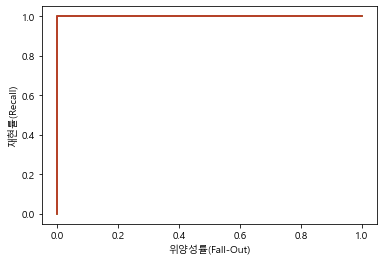

ROC_AUC :  [1.0, 1.0, 1.0, 1.0]


In [91]:
# ROC, AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# 이 아래부터 활용하면 됨
X = X_tr_o
y = label_binarize(y_tr_o, classes = [0, 1, 2, 3])   # 종속변수 y를 더미화를 시킴 / classes 이름 잘 맞춰줘야 함

n = 4 # class 개수만큼(여기선 4개였음)
fpr = [None] * n
tpr = [None] * n
threshold = [None] * n
roc_auc = []

for i in range(n):   
    model = fine_tuned_RF.fit(X, y[:, i])   # 모델링을 함
    fpr[i], tpr[i], threshold[i] = roc_curve(y[:, i], model.predict_proba(X)[:, 1])
    plt.plot(fpr[i], tpr[i])
    
    roc_auc.append(auc(fpr[i], tpr[i]))

plt.xlabel('위양성률(Fall-Out)')
plt.ylabel('재현률(Recall)')
plt.show()
print('ROC_AUC : ',roc_auc)

In [102]:
# 앙상블 모델 만들어야할 때 분류 확률 사용

model.predict_proba(X_te_s)[:,1]

array([0., 0., 0., ..., 0., 0., 0.])